In [1]:
# In this notebook, you learn:
#
# 1) How is learning rate used in transformer model?
#
# Resources to go through before continuing further with this notebook:
# 1) [LINK TO THE NOTEBOOK]
#       -- Refer to Understanding_Pytorch/misceallaneous/learning_rates.ipynb notebook to understand how lr_scheduler
#          is used with optimizers in pytorch.
#       -- This also contains resources to understand about learning rate in general.
# 2) https://nlp.seas.harvard.edu/annotated-transformer/#hardware-and-schedule
#       -- Navigate to 'Hardware and Schedule' section to understand how learning rate is used in transformer model.

In [2]:
import matplotlib.pyplot as plt
from torch import nn
from typing import Optional


import torch

In [13]:
# Number of iterations to show the learning rate updates.
num_iterations = 20000
# Number of warmup steps.
warmup_steps = 4000
# Learning rate with which the training is started. This gets updated by the learning rate scheduler periodically.
initial_learning_rate = 1.0
# Hyperparameter to calculate the m1 moment in the optimizer. This roughly corresponds to averaging over the
# last 10 (1/(1-beta_1)) sets of gradients. This comes from 'Gradient Descent with Momentum' algorithm.
beta_1 = 0.9
# Hyperparameter to calculate the m1 moment in the optimizer. This roughly corresponds to averaging over the
# last 50 (1/(1-beta_2)) sets of gradients. This comes from 'RMS prop' algorithm.
beta_2 = 0.98
# Small value to avoid division by zero in the optimizer.
epsilon = 1e-8
# Number of input features for our toy neural network.
in_features = 4
# Number of output features for our toy neural network.
out_features = 6
# Number of samples in the dataset.
num_samples = 2
# Size of the embeddings (vectors) in the transformer model. I know this is not consistent with the defined in_features
# out_features above. But this is just a toy example to understand how learning rate is used in transformer model.
d_model = 512

In [14]:
# In the transformer model, the learning rate is first increased linearly for the first warmup_steps, and then
# decreased exponentially for the rest of the training steps. The learning rate is decreased in the later
# part of the training to make the model converge to a better minima which is a standard technique. The learning
# rate is increased in the beginning during the warmup phase. Apparently, the warmup phase is used to push the 
# parameters to regions where higher learning rates can be used to make the model converge faster. This is shown
# to be true empirically using experimentation. I haven't gone through this paper (https://arxiv.org/abs//2406.09405), 
# but apparently it explains the benifits of using warmup phase with experimentation. Here is a 
# video (https://www.youtube.com/watch?v=a8yCq42IdI8) that explains the above paper. The video itself did not feel
# very beginner friendly to me, but you can give it a try.

We use the following function to update the learning rate in the transformer.

$learning\_rate = factor * (\frac{1}{d\_model} * min(\frac{1}{\sqrt{step}}, \frac{step}{warmup^{\frac{3}{2}}}))$ 

where $d\_model=512, warmup=4000$, $step$ is the number of iterations or updates to the weights, and factor just 
scales the learning rate.

Ignoring the factor (setting it to 1) for now, we get:

$learning\_rate = \frac{1}{\sqrt{d\_model}} * \frac{1}{\sqrt{step}} * min(1, \frac{step}{warmup}^{\frac{3}{2}})$

$\implies learning\_rate(step) = 
\begin{cases}
\frac{1}{d\_model} * \frac{1}{\sqrt{warmup^{\frac{3}{2}}}} * step & \text{if } step \lt warmup \\
\frac{1}{d\_model} * \frac{1}{\sqrt{step}} & \text{if } step \geq warmup \\
\end{cases}$

The case $(step \lt warmup)$ corresponds to a line with slope $(\frac{1}{d\_model} * \frac{1}{\sqrt{warmup^{\frac{3}{2}}}})$ and hence the learning_rate 
increases linearly during the warmup phase and then decreases exponentially after the warmup phase.

In [15]:
def rate(step: int, d_model: int, warmup_steps: int, factor: Optional[float] = 1.0) -> float:
    """This functions implements the above mentioned learning rate schedule. The learning rate is increased linearly
       for the first warmup_steps, and then decreased exponentially for the rest of the training steps. step 
       corresponds to 'epoch' number in the adam_optimizer functionality in pytorch.

    Args:
        step (int): current epoch number in the training loop. starts from 0.
        d_model (int): size of the vectors in the model. This is 512 in the original transformer model.
        warmup_steps (int): number of steps to increase the learning rate linearly.
        factor (Optional[float], optional): factor to scale the learning rate. Defaults to 1.0.

    Returns:
        float: returns the learning rate by which the initial learning rate should be scaled.
    """
    if step == 0:
        step = 1
    return factor * (d_model ** (-0.5) * min(step ** (-0.5), step * warmup_steps ** (-1.5)))

In [16]:
# Setup work.
# Create a simple linear layer which is our toy neural network to be passed to the optimizer.
linear_layer = nn.Linear(in_features=in_features, out_features=out_features)
print("linear_layer: ", linear_layer)
print("-" * 150)
# Create an adam optimizer to experiment with.
adam_optimizer = torch.optim.Adam(params=linear_layer.parameters(), lr=initial_learning_rate, betas=(beta_1, beta_2), eps=epsilon)
print("adam_optimizer_state: ", adam_optimizer.state_dict())
print("-" * 150)
rate_lambda = lambda step: rate(step, d_model=d_model, warmup_steps=warmup_steps, factor=1.0)
print("rate_lambda: ", rate_lambda)
print("-" * 150)
# Create a learning rate scheduler to experiment with.
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=adam_optimizer, lr_lambda=rate_lambda)
print("lr_scheduler_state: ", lr_scheduler.state_dict())


linear_layer:  Linear(in_features=4, out_features=6, bias=True)
------------------------------------------------------------------------------------------------------------------------------------------------------
adam_optimizer_state:  {'state': {}, 'param_groups': [{'lr': 1.0, 'betas': (0.9, 0.98), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1]}]}
------------------------------------------------------------------------------------------------------------------------------------------------------
rate_lambda:  <function <lambda> at 0x7f17bda3d900>
------------------------------------------------------------------------------------------------------------------------------------------------------
lr_scheduler_state:  {'base_lrs': [1.0], 'last_epoch': 0, 'verbose': False, '_step_count': 1, '_get_lr_called_within_step': False, '_last_lr': [1.746928107421711e-07], 'lr_lam

In [17]:
# Holds the learning rates to plot them later.
learning_rates = []
for step in range(num_iterations):
    # Skip the training loop i.e., the forward and backward pass.
    # Just update the learning rates.
    learning_rates.append(adam_optimizer.param_groups[0]['lr'])
    # This step is expected to be called before the lr_scheduler.step() function.
    adam_optimizer.step()
    # Updates the learning rate.
    lr_scheduler.step()
# Expect the size to be 20000.
print("length: ", len(learning_rates))

length:  20000


Text(0, 0.5, 'learning rate')

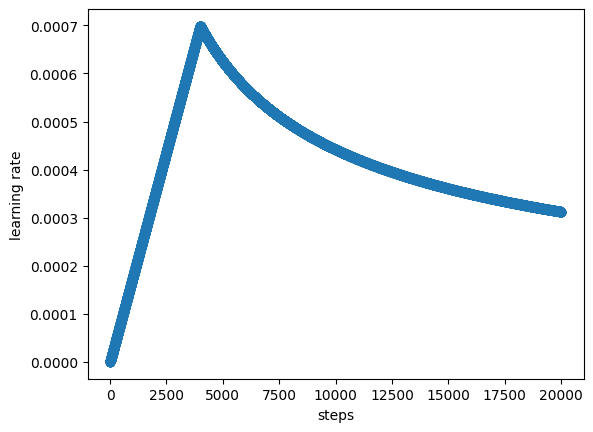

In [18]:
# Notice that the learning rate is increased linearly for the first warmup_steps (4000 steps), and then decreased 
# exponentially for the rest of the training steps.
x_axis_steps = list(range(num_iterations))
plt.plot(x_axis_steps, learning_rates, linestyle='-', marker='o')
plt.xlabel("steps")
plt.ylabel("learning rate")

In [19]:
print(learning_rates[19900:])
print(max(learning_rates))

[0.0003132841919481785, 0.00031327632078271997, 0.00031326845021051314, 0.0003132605802314836, 0.00031325271084555687, 0.0003132448420526583, 0.00031323697385271347, 0.000313229106245648, 0.0003132212392313874, 0.0003132133728098571, 0.0003132055069809828, 0.0003131976417446901, 0.0003131897771009046, 0.00031318191304955176, 0.0003131740495905574, 0.000313166186723847, 0.00031315832444934636, 0.00031315046276698103, 0.0003131426016766768, 0.0003131347411783592, 0.00031312688127195406, 0.0003131190219573871, 0.0003131111632345839, 0.0003131033051034704, 0.00031309544756397226, 0.0003130875906160152, 0.0003130797342595251, 0.0003130718784944277, 0.00031306402332064885, 0.00031305616873811433, 0.00031304831474675, 0.0003130404613464817, 0.0003130326085372352, 0.00031302475631893653, 0.0003130169046915115, 0.000313009053654886, 0.0003130012032089859, 0.00031299335335373724, 0.00031298550408906584, 0.0003129776554148978, 0.00031296980733115887, 0.00031296195983777523, 0.0003129541129346728,